In [8]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms, models, datasets
from torchvision.io import read_image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

class SpeakerIdentificationImageDataset(Dataset):
    def __init__(self, root, transform=None, target_transform=None):
        classes = pd.read_csv(root + os.sep + "classes.csv")
        annotations_file = root + os.sep + "annotations.csv"
        self.img_labels = pd.read_csv(annotations_file)
        self.root = root
        self.transform = transform
        self.target_transform = target_transform
        self.classes = [row["Name"] for index, row in classes.iterrows()]
        self.class_to_idx = {
            row["Name"]: row["Label"] for index, row in classes.iterrows()
        }

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

def count_number_of_parameters(model):
    return sum(p.numel() for p in model.parameters())


In [6]:
!pwd

/content


In [9]:
DATA_DIR = "/content/16000_pcm_speeches"
IMAGE_SIZE = 64

data_transforms = transforms.Compose(
    [
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE), antialias=True),
        transforms.ConvertImageDtype(torch.float),
    ]
)

dataset = SpeakerIdentificationImageDataset(DATA_DIR, transform=data_transforms)

train_size = int(0.9 * len(dataset))
test_size = len(dataset) - train_size
training_data, test_data = torch.utils.data.random_split(
    dataset, [train_size, test_size]
)

Shape of X [N, C, H, W]: torch.Size([1, 3, 64, 64])
Shape of y: torch.Size([1]) torch.int64

X:  tensor([[[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],

         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],

         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]]])
y:  tensor([4])
Scalar y:  4
label:  Nelson_Mandela


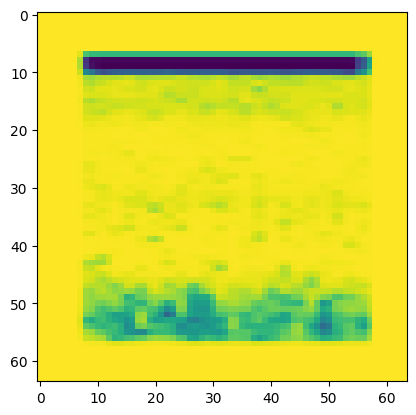

In [10]:
batch_size = 1

# Create data loaders.
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}\n")
    print("X: ", X)
    print("y: ", y)
    print("Scalar y: ", y[0].item())
    break

label = dataset.classes[y[0].item()]
print("label: ", label)
imgplot = plt.imshow(X[0][0])

In [11]:
# Get cpu, gpu or mps device for training.

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

print(f"Using {device} device")


# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn_stack = nn.Sequential(
            nn.Conv2d(3, 8, (5, 5)),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),
            nn.Conv2d(8, 4, (3, 3)),
            nn.ReLU(),
            nn.MaxPool2d((3, 3)),
            nn.Flatten(),
            nn.Linear(324, 128),
            nn.ReLU(),
            nn.Linear(128, 5)
        )

    def forward(self, x):
        logits = self.cnn_stack(x)
        return logits


model = NeuralNetwork().to(device)
print(model)
print(count_number_of_parameters(model))

Using cpu device
NeuralNetwork(
  (cnn_stack): Sequential(
    (0): Conv2d(3, 8, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(8, 4, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(3, 3), stride=(3, 3), padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=324, out_features=128, bias=True)
    (8): ReLU()
    (9): Linear(in_features=128, out_features=5, bias=True)
  )
)
43145


In [12]:
dataset.classes

['Jens_Stoltenberg',
 'Benjamin_Netanyau',
 'Julia_Gillard',
 'Magaret_Tarcher',
 'Nelson_Mandela']

In [13]:
model = NeuralNetwork().to(device)
batch_size = 1
test_dataloader = DataLoader(test_data, batch_size=batch_size)

X, y = next(iter(test_dataloader))
X = X.to(device)
print(X.shape)
pred = model(X)

pred.shape

torch.Size([1, 3, 64, 64])


torch.Size([1, 5])

In [14]:
def train(dataloader, model, loss_fn, optimizer):
    losses, accuracies = [],[]
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        optimizer.zero_grad()
        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        # Nudge
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            accuracy = (torch.sum((torch.argmax(pred, dim=1) == y).type(torch.float))/len(y)).item()
            losses.append(loss)
            accuracies.append(accuracy)
    return losses, accuracies

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [15]:

batch_size = 16

model = NeuralNetwork().to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

epochs = 5
train_losses, train_accuracies = [], []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    losses, accuracies = train(train_dataloader, model, loss_fn, optimizer)
    train_losses.extend(losses)
    train_accuracies.extend(accuracies)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 1.612798  [   16/ 6750]
loss: 1.128483  [ 1616/ 6750]
loss: 0.377635  [ 3216/ 6750]
loss: 0.178115  [ 4816/ 6750]
loss: 0.509996  [ 6416/ 6750]
Test Error: 
 Accuracy: 91.7%, Avg loss: 0.261393 

Epoch 2
-------------------------------
loss: 0.446361  [   16/ 6750]
loss: 0.219700  [ 1616/ 6750]
loss: 0.079051  [ 3216/ 6750]
loss: 0.057557  [ 4816/ 6750]
loss: 0.162586  [ 6416/ 6750]
Test Error: 
 Accuracy: 94.8%, Avg loss: 0.143134 

Epoch 3
-------------------------------
loss: 0.184036  [   16/ 6750]
loss: 0.039539  [ 1616/ 6750]
loss: 0.080120  [ 3216/ 6750]
loss: 0.011915  [ 4816/ 6750]
loss: 0.089552  [ 6416/ 6750]
Test Error: 
 Accuracy: 97.1%, Avg loss: 0.088643 

Epoch 4
-------------------------------
loss: 0.094830  [   16/ 6750]
loss: 0.020571  [ 1616/ 6750]
loss: 0.038223  [ 3216/ 6750]
loss: 0.005156  [ 4816/ 6750]
loss: 0.058769  [ 6416/ 6750]
Test Error: 
 Accuracy: 99.1%, Avg loss: 0.035757 

Epoch 5
------------------------

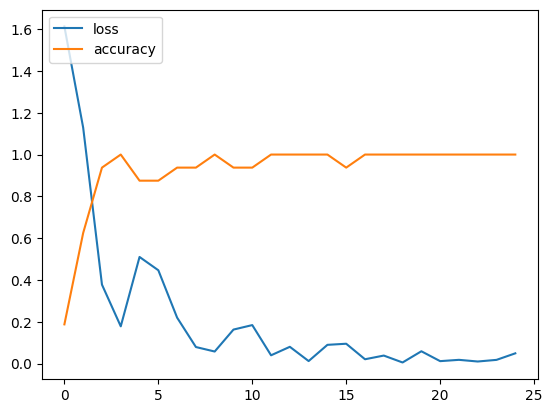

In [16]:
plt.plot(train_losses, label = "loss")
plt.plot(train_accuracies, label = "accuracy")
plt.legend(loc="upper left")

plt.show()

In [ ]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

In [ ]:
model = NeuralNetwork().to(device)
model.load_state_dict(torch.load("model.pth"))

In [ ]:
index = torch.randint(len(test_data), ()).item()

X, y = test_data[index]

X = X[None, :]

imgplot = plt.imshow(X[0][0])

model.eval()
with torch.no_grad():
    X = X.to(device)
    pred = model(X)

class_index = torch.squeeze(torch.argmax(pred, dim=1)).item()

print(
    f"Predicted: {test_data.dataset.classes[class_index]} Actual: {test_data.dataset.classes[y]}"
)

In [ ]:
X.shape

model(X)

In [ ]:
test_data.dataset.class_to_idx

In [ ]:
print(test_data.dataset.class_to_idx)

In [ ]:
X[0][0].shape